# Evaluation Notebook

**Description**

This notebook uses the output from each method to evalute their output using F1, F1_CTP, Precision, Precision_CTP
You can access the output that we had for each method in this [DRIVE LINK](https://drive.google.com/file/d/1ns10fCc7Mz1W2wAvj39jbLxQmVyg8ufI/view?usp=sharing)

----

Author: João Phillipe Cardenuto\
Email: phillipe.cardenuto@ic.unicamp.br\
December, 2020
----


In this notebook we use the additional modules:\
prettytable\
`pip install prettytable`\
tqdm\
`pip install tqdm`\



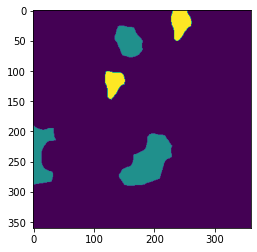

In [232]:
plt.imshow(Image.open("/work/jcardenuto/translate-forgery-algs/python-CMFD-adaptative-oversegmentation/python/results_new/simple/forgery/duplication/copy-move/random/00230/figure_forgery_final_map_ids.png"))

In [1]:
# Including path to forgery_lib dataset on the notebook
# LIB_PATH = "../"
# import sys
# sys.path.append(LIB_PATH)

from glob import glob
import cv2
import numpy as np
from prettytable import PrettyTable
import os 
from metrics import (F1, precision, F1_CTP, precision_CTP)
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
import pandas as pd

# Run Evaluation on the TESTSET - Simple Figures

### Duplication

In [2]:
def vole_evaluation(result, gt_pristine, gt_forgery):
    """
    Evaluates the output from the method Christlein et al. (2012) “An evaluation of popular
    copy-move forgery detection approaches". For this we use a modified version inside 
    the detection_method directory in this from this repository.
    
    """
    
    result = cv2.imread(result, cv2.IMREAD_GRAYSCALE)
    
    # Insert pristine regions and forgery regions in the same map
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc


def patch_match_evaluation(result, gt_pristine, gt_forgery):
    """
    Evaluates the output from the method from Cozzolino et al. (2015) “Efficient dense-field 
    copy-move forgery detection”, from the implemented version of Ehret (2018), “Automatic detection of internal copy-move
    forgeries in images”. For this we use a modified version inside the detection_method directory in this from this repository.
    
    """
    
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    result = np.fromfile(result,np.int32).reshape(gt_pristine.shape).astype("uint8")
    
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def busternet_evaluation(result_path, gt_pristine, gt_forgery):
    """
    Evaluates the output from Wu et al. (2018) "Busternet: Detecting image copy-move forgery with source/target localization".
    To generate the ouput, we used the pre-trained model from https://github.com/isi-vista/BusterNet
    """
    
    result = cv2.imread(result_path)
    # Make the output of busternet as binary
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB).astype("uint8")
    output_format = np.zeros((result.shape[0],result.shape[1])).astype("uint8")
    # If the color of the output is RED or GREEN insert it on output_format
    output_format[ result[:,:,0] > 100] = 1
    output_format[ result[:,:,1] > 100] = 1
    result = output_format
    
    if 'pristine' in result_path:
        gt_forgery = np.zeros((result.shape[0],result.shape[1])).astype("uint8")
        
    else:     
        gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
        gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
        
        # Pre-process gt_forgery as the output of busternet
        gt_forgery [ gt_pristine > 0] = 1
        gt_forgery = cv2.resize(gt_forgery, (result.shape[1],result.shape[0]))
        gt_forgery[gt_forgery > 0] = 1
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def overseg_evaluation(result_path, gt_pristine, gt_forgery):
    """
    Evaluates the output from Pun et al. (2015) "Image forgery detection using adaptive over-segmentation and feature points matching".
    We base our implementation in the Pun et al. article and in the MatLab code from the github user MohenseZandi
    """
    
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    result = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)
    
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def hfpm_evaluation (result_path, gt_pristine, gt_forgery):
    """
    Evaluates the output from Pun et al. (2015) "Fast and Effective Image Copy-Move Forgery Detection via Hierarchical Feature Point Matching".
    We base our implementation in the Yuanman et al. article and in the original Matlab code https://github.com/YuanmanLi/FE-CMFD-HFPM
    """
    
    gt_forgery = cv2.imread(gt_forgery, cv2.IMREAD_GRAYSCALE)
    gt_pristine = cv2.imread(gt_pristine, cv2.IMREAD_GRAYSCALE)
    result = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)
    
    a = np.unique(gt_pristine)
    a = a[a!=0]
    for i in a:
        gt_forgery[gt_pristine == i] = i
    
    f1 = F1(result,gt_forgery)
    f1_cc = 0 if f1==0 else F1_CTP(result,gt_forgery) # Optimize f1_cc to avoid check when f1 is 0
    p = precision(result,gt_forgery)
    p_cc = 0 if p==0 else precision_CTP(result,gt_forgery) # Optimize p_cc to avoid check when p is 0
    
    return f1, f1_cc ,p, p_cc

def check_output(detection_output, gt_forgery, gt_pristine, method):
    
    if not os.path.isfile(detection_output):
        return (0,0,0,0)
    
    if method == 'vole':
        return vole_evaluation(detection_output, gt_pristine, gt_forgery)
    elif method == 'pm': #patchmacth
        return patch_match_evaluation(detection_output, gt_pristine, gt_forgery)
    elif method == 'busternet':
        return busternet_evaluation (detection_output, gt_pristine, gt_forgery)
    elif method == 'overseg':
        return overseg_evaluation (detection_output, gt_pristine, gt_forgery)
    elif method == 'hfpm':
        return hfpm_evaluation (detection_output, gt_pristine, gt_forgery)
    
    return (0,0,0,0)
        

# Evaluating Copy-Move Simple Figures
Here we evaluate copy move images for duplication propose and for cleaning propose.

In a duplication forgery, an object is paste on the top of a background region

In a cleaning forgery, a background region is pasted on the top of a object (hidden the object).

-----
### Detection Methods
- SURF
- SIFT
- Zernike using PatchMatch
- Sift using PatchMatch

# Compound Figures

In [3]:
test_path = '/work/jcardenuto/translate-forgery-algs/tmp/'
test_compound_figures = glob(f'{test_path}testset/compound/**/annotations.json',recursive=True)
test_compound_figures = [t.replace(test_path,'') for t in test_compound_figures]

In [4]:
def run_parallel(input):
    
    surf_vole, sift_vole, sift_pm, zernike_pm, busternet,overseg, hfpm, gt_pristine, gt_forgery = input
    output = []
    try:
        f1, f1_cc ,p, p_cc = check_output(surf_vole, gt_pristine, gt_forgery,'vole')
    except:
        print(f'detect error img {surf_vole}')
        f1, f1_cc ,p, p_cc = (0,0,0,0)
    output.append((f1, f1_cc ,p, p_cc,"SURF-VOLE"))
    
    try:
        f1, f1_cc ,p, p_cc = check_output(sift_vole, gt_pristine, gt_forgery,'vole')
    except:
        print(f'detect error img {sift_vole}')
        f1, f1_cc ,p, p_cc = (0,0,0,0)
    output.append((f1, f1_cc ,p, p_cc,"SIFT-VOLE"))

    try:
        f1, f1_cc ,p, p_cc = check_output(sift_pm, gt_pristine, gt_forgery,'pm')
    except:
        print(f'detect error img {sift_pm}')
        f1, f1_cc ,p, p_cc = (0,0,0,0)
    output.append((f1, f1_cc ,p, p_cc,"SIFT-PM"))
    
    try:
        f1, f1_cc ,p, p_cc = check_output(zernike_pm, gt_pristine, gt_forgery,'pm')
    except:
        print(f'detect error img {zernike_pm}')
        f1, f1_cc ,p, p_cc = (0,0,0,0)
    output.append((f1, f1_cc ,p, p_cc,"ZERNIKE-PM"))
    
    try:
        f1, f1_cc ,p, p_cc = check_output(busternet, gt_pristine, gt_forgery,'busternet')
    except:
        print(f'detect error img {busternet}')
        f1, f1_cc ,p, p_cc = (0,0,0,0)
    output.append((f1, f1_cc ,p, p_cc,"BUSTERNET"))
        
    try:
        f1, f1_cc ,p, p_cc = check_output(overseg, gt_pristine, gt_forgery,'overseg')
    except:
        print(f'detect error img {overseg}')
        f1, f1_cc ,p, p_cc = (0,0,0,0)
    output.append((f1, f1_cc ,p, p_cc,"OVERSEG"))

    try:
        f1, f1_cc ,p, p_cc = check_output(hfpm, gt_pristine, gt_forgery,'hfpm')
    except:
        print(f'detect error img {hfpm}')
        f1, f1_cc ,p, p_cc = (0,0,0,0)
    output.append((f1, f1_cc ,p, p_cc,"HFPM"))
    
    return output
    
    
#COMPOUND_EVAL = pd.DataFrame(columns=['F1','Precision','Method', "Detection-Map"])
input_list = []
for test_figure in tqdm(test_compound_figures):
    
    if 'splicing' in test_figure:
        gt_forgery =  test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_host_gt.png"
        gt_pristine =  test_path + os.path.sep + os.path.dirname(test_figure) + os.path.sep + "figure_donor_gt.png"
        
    else:
        gt_forgery = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_forgery_gt.png"
        gt_pristine = test_path + os.path.sep +  os.path.dirname(test_figure) + os.path.sep + "figure_pristine_gt.png"
    
    surf_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_surf_figure_v3_labeled.png"
    sift_vole = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "vole_sift_figure_v3_labeled.png"
    sift_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_sift_figure_v3.png.bin"
    zernike_pm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "fd_zernik_figure_v3.png.bin"
    busternet = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "busternet_figure_v3_forgery.png"
    overseg = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "overseg_figure_v3_detection_map.png"
    hfpm = os.path.dirname(test_figure.replace('testset','output')) + os.path.sep + "hfpm_figure_v3_detection_map.png"
    
    input_list.append((surf_vole, sift_vole, sift_pm, zernike_pm, busternet, overseg, hfpm, gt_pristine, gt_forgery))

In [5]:
output_list = process_map(run_parallel, input_list, chunksize=1, max_workers=70)

# Continue from here

In [7]:
COMPOUND_EVAL = pd.DataFrame(columns=['F1','F1-Check', 'Precision', 'Precision-Check','Method', "Detection-Map"])
for index, item in enumerate(output_list):
    
    surf_vole, sift_vole, sift_pm, zernike_pm, busternet, overseg, hfpm, gt_pristine, gt_forgery = input_list[index]
    f1, f1_cc, p, p_cc = item[0][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SURF-VOLE', "Detection-Map": surf_vole}))
    
    f1, f1_cc, p, p_cc = item[1][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-VOLE', "Detection-Map": sift_vole}))
    
    f1, f1_cc, p, p_cc = item[2][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'SIFT-PM', "Detection-Map": sift_pm}))
    
    f1, f1_cc, p, p_cc = item[3][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'ZERNIKE-PM', "Detection-Map": zernike_pm}))
    
    f1, f1_cc, p, p_cc = item[4][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'BUSTERNET', "Detection-Map": busternet}))
    
    f1, f1_cc, p, p_cc = item[5][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'OVERSEG', "Detection-Map": overseg}))
    
    f1, f1_cc, p, p_cc = item[6][:4]
    COMPOUND_EVAL = COMPOUND_EVAL.append(pd.DataFrame({'F1':[f1],'F1-Check':[f1_cc],'Precision':[p],'Precision-Check':[p_cc], "Method":'HFPM', "Detection-Map": hfpm}))
    

In [8]:
COMPOUND_EVAL.sort_values(by=['F1']).iloc[-50:]

,F1,F1-Check,Precision,Precision-Check,Method,Detection-Map
0,0.993028,0.993028,0.986152,0.986152,SIFT-VOLE,output/compound/inter-panel/duplication/copy-m...
0,0.993036,0.993036,0.986168,0.986168,SURF-VOLE,output/compound/inter-panel/duplication/copy-m...
0,0.993076,0.993076,0.986678,0.986678,SURF-VOLE,output/compound/inter-panel/duplication/copy-m...
0,0.993087,0.993087,0.986268,0.986268,SIFT-VOLE,output/compound/inter-panel/duplication/copy-m...
0,0.993092,0.993092,0.986663,0.986663,SIFT-VOLE,output/compound/inter-panel/duplication/copy-m...
0,0.993097,0.993097,0.986288,0.986288,SURF-VOLE,output/compound/inter-panel/duplication/copy-m...
0,0.993116,0.993116,0.989016,0.989016,SURF-VOLE,output/compound/inter-panel/duplication/copy-m...
0,0.99312,0.99312,0.991263,0.991263,SURF-VOLE,output/compound/inter-panel/duplication/copy-m...
0,0.993159,0.993159,0.989196,0.989196,SURF-VOLE,output/compound/inter-panel/duplication/copy-m...
0,0.993236,0.993236,0.986572,0.986572,SURF-VOLE,output/compound/inter-panel/duplication/copy-m...


In [9]:
COMPOUND_EVAL = COMPOUND_EVAL.reset_index()

In [10]:
from datetime import datetime
# Save CSV file
COMPOUND_EVAL.to_csv(f'compound_v3_{datetime.now().strftime("20%y-%m-%d-%H-%M")}.csv')

In [11]:
from glob import glob
import cv2
import numpy as np
from prettytable import PrettyTable
import os 
from metrics import (F1, precision, F1_CTP, precision_CTP)
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
import pandas as pd

In [12]:
modalities = set([os.path.dirname(os.path.dirname(i[0])) for i in input_list])

In [19]:
# COMPOUND_EVAL = pd.read_csv('compound_v1_2022-02-24-13-11.csv')

In [13]:
COMPOUND_EVAL['MODALITY'] = None

for index, row in COMPOUND_EVAL.iterrows():
    modality = row['Detection-Map']
    modality = "/".join(modality.split("/")[1:-2])
    COMPOUND_EVAL.loc[index, 'MODALITY'] = modality
    

# Verbosity - 3

In [14]:
###  Modality - F1 Score (No consistent Check)
x = PrettyTable()
x.field_names = ["Modality - F1 Score", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['F1', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)

###  Modality - F1 Score CTP (WITH consistent Check)
x = PrettyTable()
x.field_names = ["Modality - F1 - Score with Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['F1-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET', 'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)

###  Modality - Precision Score (No consistent Check)
x = PrettyTable()
x.field_names = ["Modality - Precision", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['Precision', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']] )
            
print(x)
print("="*130)
print("-"*130)
print("="*130)


###  Modality - Precision Score (With consistent Check)
x = PrettyTable()
x.field_names = ["Modality - Precision with Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1].drop(columns=["index"])
    means = {}
    for method, result in modality[['Precision-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET',  'OVERSEG', 'HFPM']] )
            
print(x)

# print(x.get_csv_string(delimiter='\t'))

+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+---------+---------+
|                               Modality - F1 Score                                | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET | OVERSEG |   HFPM  |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+---------+---------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.00141   | 0.06400 |  0.03005  |  0.01820  |  0.17294  | 0.23017 | 0.02638 |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.00826   | 0.01953 |  0.00722  |  0.01116  |  0.13658  | 0.18535 | 0.01246 |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.06750   | 0.58851 |  0.52869  |  0.52754  |  0.18360  | 0.36432 | 0.33410 |
| compound/inter

In [17]:
x = PrettyTable()
x.field_names = ["Modality - F1 Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['F1-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)
print(x.get_csv_string(delimiter='\t'))

+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                               Modality - F1 Check                                | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.00038   | 0.04879 |  0.03346  |  0.03735  |  0.13116  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.00849   | 0.00703 |  0.00541  |  0.01256  |  0.11566  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.06647   | 0.55762 |  0.56854  |  0.59223  |  0.14261  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00000   | 0.01377 |  0.66468  |  0.57795  |  0.1

In [18]:
x = PrettyTable()
x.field_names = ["Modality - Precision", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['Precision', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)
print(x.get_csv_string(delimiter='\t'))

+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                               Modality - Precision                               | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.01529   | 0.10145 |  0.08281  |  0.08047  |  0.10723  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.01389   | 0.03940 |  0.01726  |  0.03493  |  0.08231  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.10861   | 0.50043 |  0.60406  |  0.65120  |  0.11678  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00649   | 0.06457 |  0.71429  |  0.69892  |  0.0

In [19]:
x = PrettyTable()
x.field_names = ["Modality - Precision Check", "ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']
    
for g in COMPOUND_EVAL.groupby('MODALITY'):
    modality_name = g[0]
    
   
    modality = g[1]
    means = {}
    for method, result in modality[['Precision-Check', 'Method']].groupby("Method"):
         means[method] = "%0.5f"%result.mean()[0]
    
    x.add_row([modality_name] +[ means[method] for method in ["ZERNIKE-PM",'SIFT-PM', "SURF-VOLE", "SIFT-VOLE", 'BUSTERNET']] )
            
print(x)
print(x.get_csv_string(delimiter='\t'))

+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|                            Modality - Precision Check                            | ZERNIKE-PM | SIFT-PM | SURF-VOLE | SIFT-VOLE | BUSTERNET |
+----------------------------------------------------------------------------------+------------+---------+-----------+-----------+-----------+
|    compound/inter-panel/duplication/copy-move/geometric_transformations/flip     |  0.00234   | 0.07919 |  0.07244  |  0.07683  |  0.07934  |
|   compound/inter-panel/duplication/copy-move/geometric_transformations/flip90    |  0.01080   | 0.01432 |  0.01522  |  0.03257  |  0.06743  |
|    compound/inter-panel/duplication/copy-move/geometric_transformations/none     |  0.09992   | 0.47748 |  0.59983  |  0.65117  |  0.08887  |
| compound/inter-panel/duplication/copy-move/geometric_transformations/rotation180 |  0.00000   | 0.02494 |  0.71010  |  0.69892  |  0.0